# Solving a max-cut problem using QAOA

## What is max-cut problem?

Based on the [Wikipedia page](https://en.wikipedia.org/wiki/Maximum_cut), a maximum cut of a graph is a cut whose size is at least the size of any other cut. In other words, a maximum cut divides the vertices into two complementary sets $S$ and $T$, such that the number of edges between the two sets is as large as possible. For weighted graphs, the sum of the weights of the shared edges should be maximized. 

## What is QAOA?

Quantum Approximate Optimization Algorithm (QAOA), is a method for solving combinatorial optimization problems on NISQ devices. It can be used to find approximate solutions to problems that can be phrased as finding the optimal bitstring. The steps of this algorithm can be described as follows (taken from [PennyLane Demo "Intro to QAOA"](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html)):

1. Define a cost Hamiltonian $H_C$. We should be able to obtain the solution to the optimization problem from its ground state. 
2. Define a mixer Hamiltonian $H_M$. 
3. Construct circuits $e^{-i\gamma H_C}$ and $e^{-i\alpha H_M}$.
4. Choose a parameter $n\geq1$, and building $n$ layers of circuit $U(\boldsymbol\gamma, \boldsymbol\alpha)=e^{-i\alpha_nH_M}e^{-i\gamma_nH_C}...e^{-i\alpha_1H_M}e^{-i\gamma_1H_C}$.
5. Prepare an initial state, apply $U(\boldsymbol\gamma, \boldsymbol\alpha)$, use classical techniques to optimize the parameters.
6. Approximate solutions is obtained by measuring the final output state.

## Apply QAOA to the max-cut problem

It turns out that the max-cut problem is demonstrated [in the Qiskit textbook](https://learn.qiskit.org/course/ch-applications/solving-combinatorial-optimization-problems-using-qaoa#QAOA). This notebook will be referencing to this textbook a lot.  
Consider a graph $G(V,E)$ with $n$ nodes. Write the weight of edges as $w_{ij}=w_{ji}>0$ for $(i,j)\in E$. $w_{ij}$ can be set to 0 for any $(i,j)\notin E$.  Assign values $x_i=0$ or $x_i=1$ to each node $x_i$ representing which partition it belongs to, the max cut problem becomes the problem of maximzing the following function:
$$
C(\boldsymbol x)=\sum_{i,j=1}^nw_{ij}x_i(1-x_j)=\sum_{(i,j)\in E}w_{ij}(x_i(1-x_j)+x_j(1-x_i))
$$  
Assuming uniform weight $w_{ij}=1$, the problem hamiltonian thus can be written as  
$$
H_P = {1\over2}\sum_{i,j\in E(G)}(1-Z_i\otimes Z_j)
$$  
by setting $x_i = (1-Z_i)/2$, where $Z_i$ is the Pauli Z operator with eigenvalues $\pm 1$.  
The mixing Hamiltonian is  
$$
H_M = \sum_{i\in V(G)}X_i
$$  
where $X_i$ is the PauliX operator.  

In [2]:
from IPython.core.display import clear_output
# install qiskit
!pip install qiskit
clear_output()

In [3]:
# import necessary libraries

# For graph and plotting
import networkx as nx
import matplotlib.pyplot as plt

# For quantum circuits
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram

# For optimization
import numpy as np
from scipy.optimize import minimize




### Create a graph
First, let's create a simple graph with 6 nodes, each node only connected to its immediate neighbors. The solution to the max-cut problem for this graph is a split such that all odd nodes are in one set and all even ones are in the other.

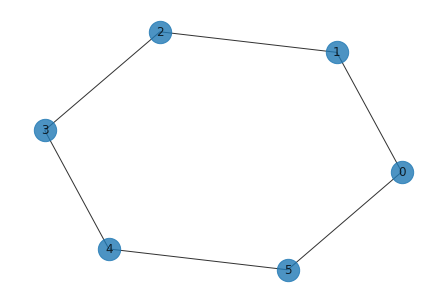

In [4]:
n_nodes = 6
G = nx.Graph()
G.add_nodes_from(range(n_nodes))
G.add_weighted_edges_from([(i,(i+1)%n_nodes, 1.0) for i in range(n_nodes)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

### Create the QAOA circuit

#### The Initial State

We create an initial state that's an equal superposition of all the basis states,

$$|\psi_0\rangle=\left({1\over\sqrt2}\left(|0\rangle+|1\rangle\right)\right)^{\otimes n}$$

#### Create the Unitaries

In the algorithm, the unitary operators we are actually applying are $e^{-i\alpha H_M}$ and $e^{-i\gamma H_P}$. They can both be broken down into individual parts as  
$$
\begin{align}
U(H_M)&=e^{-i\alpha H_M}=\prod_{i\in V(G)}e^{-i\alpha X_i}  \\ U(H_P)&=e^{-i\gamma H_P}=\prod_{i,j\in E(G)}e^{-i{\gamma\over2}(1- Z_iZ_j)}
\end{align}
$$  
Each term in $U(H_M)$ corresponds to a X-rotation. Each term in $U(H_P)$ can be realized using $C_{u1}(-2\gamma)_{i,j}u1(\gamma)_iu1(\gamma)_j$, where $C_{u1}$ is a controlled phasegate and $u1$ is a phasegate.

#### Measurements

We measure all quibits at the end of the circuit as the output.

In [15]:
def build_qaoa_circ(G, theta):
  """
  Creates a QAOA circuit parametrized by theta

  Args:
    G: networkx graph
    theta: list
           parameters for the unitary operators
  
  Returns:
    qc: qiskit circuit
  """

  nqubits = len(G.nodes())
  depth = len(theta)//2 # number of "layers" of laternating unitaries
  qc = QuantumCircuit(nqubits)
  beta = theta[:depth]
  gamma = theta[depth:]

  # initialize the circuit with Hadamard gates
  for i in range(nqubits):
    qc.h(i)

  # add unitary layers
  for j in range(depth):

    # problem unitary
    for pair in list(G.edges()):
      # qc.rzz(2 * gamma[j], pair[0], pair[1])
      k = pair[0]
      l = pair[1]
      qc.cp(-2*gamma[j], k, l)
      qc.p(gamma[j], k)
      qc.p(gamma[j], l)

    # mixing unitary
    for i in range(nqubits):
      qc.rx(2*beta[j], i)

  # measurement
  qc.measure_all()

  return qc


### The Cost Function

We sample the circuits many times and use the sampling results to compute the expectation value of the problem Hamiltonian, which is what we are trying to minimize.  
Given counts of different bit strings that represents different ways to partition the graph, we can compute the expectation value as follows:  
$$\langle H_P\rangle=-\sum_{x\in samples}n_{edges, x}\times n_x$$
where $n_{edges,x}$ is the number of edges share between the partitions represented by $x$ and $n_x$ is the number of times $x$ shows up in the samples. 
We write separate functions for calculating $n_{edges, x}$, computing the expectation value, and sample from the circuit.

In [8]:
def cost_function(x, G):
  """
  Given a bitstring x representing a bipartite, this function returns the number of edges shared between the two partitions of the graph.

  Args:
    x: str
      bitstring representing a birpartite of the graph
    G: networkx graph

  Returns:
    C: float
       cost function of a given partition
  """

  C = 0
  E = G.edges()
  for pair in E:
    i = pair[0]
    j = pair[1]
    w = G[e1][e2]['weight']
    C = C ＋ x[i]*(1-x[j])+x[j]*(1-x[i])
            
  return C

def compute_expectation(counts, G):
  """
  Computes expectation value based on measurement results
    
  Args:
    counts: dict
            key as bitstring, val as count
           
    G: networkx graph
        
  Returns:
    EV: float
        expectation value
  """

  EV = 0
  total_count = 0
  for x, count in counts.items():
    C = cost_function(x, G)
    EV -= C*count
    total_count += count

  return EV/total_count

def expectation_from_sample(G, shots = 2000):
  """
  Runs the QAOA circuit.

  Args:
    G: networkx graph
    depth: int
           number of "layer"s of unitaries
  """

  backend = Aer.get_backend('qasm_simulator')
  backend.shots = shots

  def execute_circ(theta):
        
    qc = build_qaoa_circ(G, theta)
    counts = backend.run(qc, seed_simulator=10, 
                            shots=shots).result().get_counts()
        
    return compute_expectation(counts, G)
    
  return execute_circ

### Minimizing the Cost Function

In [16]:
expectation = expectation_from_sample(G)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res

     fun: -4.53
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 27
  status: 1
 success: True
       x: array([1.17007057, 0.78031701])

### Check the Result

In [17]:
from numpy.lib.utils import source
backend = Aer.get_backend('aer_simulator')
backend.shots = 100000

qc_res = build_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10, shots = 50000).result().get_counts()

sorted_counts = sorted(counts, key=counts.get, reverse=True)
for x in sorted_counts[:10]:
  print(x, counts[x])

010101 7311
101010 7128
100101 1698
011001 1654
001101 1648
001001 1644
110100 1637
011010 1626
110010 1625
010011 1623


The top two solutions are as expected. The odd nodes are in one set and the even nodes are in the other.

## Test On a Different Graph

Let's generate a random graph with 12 nodes and 16 edges.

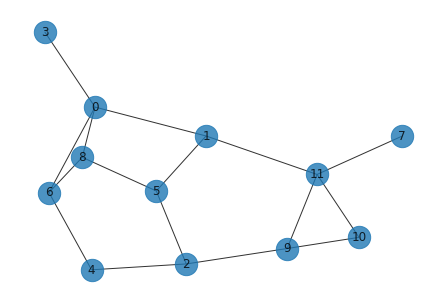

In [24]:
n_nodes = 12
Gr = nx.gnm_random_graph(n_nodes, 16)
nx.draw(Gr, with_labels=True, alpha=0.8, node_size=500)

In [25]:
depth = 8
np.random.seed(0)
params = np.random.rand(depth*2)

expectation = expectation_from_sample(Gr, shots = 200000)

res = minimize(expectation, 
                      params, 
                      method='COBYLA')
res

     fun: -8.34387
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 160
  status: 1
 success: True
       x: array([1.54827739, 0.65021144, 1.73617242, 1.42026039, 1.51712331,
       0.62122886, 0.5230015 , 0.6465582 , 1.06244773, 0.16540905,
       1.1068396 , 0.4027258 , 0.86355238, 0.69101962, 1.1321565 ,
       0.14563857])

In [27]:
backend = Aer.get_backend('aer_simulator')

qc_res = build_qaoa_circ(Gr, res.x)

counts = backend.run(qc_res, seed_simulator=10, shots = 200000).result().get_counts()

sorted_counts = sorted(counts, key=counts.get, reverse=True)
for x in sorted_counts[:10]:
  print(x, counts[x], shared_edges(x, Gr))

010110101011 497 10
100100101011 479 7
101001010100 467 10
011011010100 428 7
100101001101 427 10
011010110010 405 10
100000001100 368 8
011111110011 365 8
011000001000 361 9
110011010100 359 12


Let's compare this to directly evaluating the shared edges in each possible bitstring x.

In [28]:
sharede = {}
for i in range(2**n_nodes):
  num = i
  bits = np.zeros(n_nodes)
  pos = n_nodes-1
  while num > 0:
    bits[pos] = num%2
    num = num//2
    pos -= 1
  bitstring = ''.join([str(digit) for digit in bits.astype(int)])  
  # print(bitstring)
  sharede[bitstring] = cost_function(bitstring, Gr)
sortedse = sorted(sharede, key = sharede.get, reverse = True)
print('The top solutions are:\n')
for x in sortedse[:10]:
  print(x, sharede[x])

print('The shared edges of solutions obtained from the QAOA circuit:\n')
for x in sorted_counts[:10]:
  print(x, sharede[x])

The top solutions are:

011100111010 14
100011000101 14
010110011100 13
010110011110 13
011000111010 13
011100011010 13
011100101001 13
011100101010 13
011100101011 13
011100110010 13
The shared edges of solutions obtained from the QAOA circuit:

010110101011 10
100100101011 7
101001010100 10
011011010100 7
100101001101 10
011010110010 10
100000001100 8
011111110011 8
011000001000 9
110011010100 12


In [ ]:
2**12

4096